In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import holidays
import requests

## FUNCTIONS - GENERATION OPERATIONS

In [2]:
def gen_stats(hist_supp):
  start = time.time()

  my_agg = {'mwh' : ['mean', 'std']}

  sources = ['Photovoltaic', 'Wind', 'Hydro', 'Thermal', 'Geothermal']
  supp_stats = hist_supp.groupby(['source', 'time']).agg(my_agg).reset_index()
  supp_stats = supp_stats.loc[supp_stats.source.isin(sources), :]
  supp_stats.columns = ['source', 'time', 'mwh_mean', 'mwh_std']

  supp_stats_mean = supp_stats[['source', 'time', 'mwh_mean']]
  supp_stats_std = supp_stats[['source', 'time', 'mwh_std']]

  supp_stats_mean = supp_stats_mean.pivot_table(index=['time'], columns=['source'], values=['mwh_mean']).reset_index()
  supp_stats_mean.columns = ['time', 'Geothermal', 'Hydro', 'Photovoltaic', 'Thermal', 'Wind']
  supp_stats_mean = supp_stats_mean[sources]
  supp_stats_mean = np.array(supp_stats_mean)

  supp_stats_std = supp_stats_std.pivot_table(index=['time'], columns=['source'], values=['mwh_std']).reset_index()
  supp_stats_std.columns = ['time', 'Geothermal', 'Hydro', 'Photovoltaic', 'Thermal', 'Wind']
  supp_stats_std = supp_stats_std[sources]
  supp_stats_std = np.array(supp_stats_std)

  end = time.time()
  elapsed = end - start
  print(f'Executed in {np.round(elapsed, 2)}s')
  print('Column order: PV, WIND, GEOTHERMAL, THERMAL, HYDRO')

  return supp_stats_mean, supp_stats_std

In [3]:
def generation_mix(total_generators: int, percentages: np.ndarray, gen_mean, gen_std) -> np.ndarray:

    if len(percentages) != 5:
        raise ValueError("Percentages array must contain exactly 5 elements")

    if not np.isclose(np.sum(percentages), 1):
        raise ValueError("Percentages must sum to 1")

    # Calculate number of generators for each energy source
    generators = np.array([
        int(total_generators * percentages[0]),  # PV
        int(total_generators * percentages[1]),  # Wind
        int(total_generators * percentages[2]),  # Geo
        int(total_generators * percentages[3]),  # Therm
        int(total_generators * percentages[4])   # Hydro
    ])

    # Handle rounding errors
    diff = total_generators - np.sum(generators)
    if diff != 0:
        print('Adjusting percentages to match #total_generator')
        # Adjust the largest category to account for rounding errors
        generators[np.argmax(percentages)] += diff

    energy_mix = np.zeros((24, np.sum(generators)))

    for h in range(24): # hour
      u = 0
      source_index = 0
      for s in generators: # number of generator per source
        if s == 0:
          k = 10
        else:
          k = 1
        mu = gen_mean[h, source_index] * k
        sigma = gen_std[h, source_index]

        energy_mix[h, u:u + s] = np.random.normal(loc = mu,  scale = sigma, size = s)
        u += s
        source_index += 1

    return energy_mix, generators

In [55]:
def scale_gen(mix, demand, mix_excess: float): # since generation data was obtained from regional data, without specifics about single plants
  if mix_excess > 1 or mix_excess < 0:
    raise ValueError("mix_excess must be > 0 and < 1")

  mix_sum = np.sum(mix, axis = 1)
  demand_sum = np.sum(demand, axis = 1)

  target_generation = demand_sum * (1 + mix_excess)
  scaling_factors = target_generation / mix_sum
  scaled_mix = mix * scaling_factors[:, np.newaxis]

  scaled_mix_sum = np.sum(scaled_mix, axis=1)  # should match

  return scaled_mix

def generation_prices(generators, prices_matrix):
  arr_to_fill = np.zeros((24, np.sum(generators)))

  for h in range(24):
    u = 0
    source_index = 0

    for s in generators:
      base_price = prices_matrix[h, source_index]
      adj = 1 + np.random.uniform(-.02, .02, s)
      adj_price = base_price * adj
      arr_to_fill[h, u:u+s] = adj_price

      u += s
      source_index += 1

  return arr_to_fill

## FUNCTIONS - RANDOM PLOTS OF DEMAND/SUPPLY + SMP CALCULATOR

In [36]:
def random_demand(demand, n_participants = 1):

  demand_participants = demand.shape[1]
  for i in range(n_participants):
      rnd_num = np.random.randint(demand_participants)
      rnd_demand = demand[:, rnd_num]
      rnd_demand_consump = np.sum(rnd_demand, axis = 0)
      print(f'Among the {demand_participants}, I am plotting #: {rnd_num}; daily energy consumption: {np.round(rnd_demand_consump, 1)} MWh')
      plt.plot(rnd_demand, label = rnd_num, alpha = .6, marker = 'o')
  plt.ylabel('Load [MWh]')
  plt.xlabel('Time [h]')
  plt.legend()
  plt.show()

def random_supply(supply, n_participants):

  supply_participants = supply.shape[1]
  for i in range(n_participants):
      rnd_num = np.random.randint(supply_participants)
      rnd_supply = supply[:, rnd_num]
      rnd_supply_consump = np.sum(rnd_supply, axis = 0)
      print(f'Among the {supply_participants}, I am plotting #: {rnd_num}; daily energy offer: {np.round(rnd_supply_consump, 1)} MWh')
      plt.plot(rnd_supply, label = rnd_num, alpha = .6, marker = 'o')
  plt.ylabel('Load [MWh]')
  plt.xlabel('Time [h]')
  plt.legend()
  plt.show()

def calculate_smp(supply, demand, supply_prices, demand_prices, plot = False):

  smp = []
  for h in range(24):

    # sort supply and demand prices, increasing and decreasing order, respectively
    sup_prices = supply_prices[h]
    sup_quantities = supply[h]

    valid_indices = np.where(sup_prices != np.isnan)
    sup_prices = sup_prices[valid_indices]
    sup_quantities = sup_quantities[valid_indices]

    sorted_supply_indices = np.argsort(sup_prices)
    sorted_supply_prices = sup_prices[sorted_supply_indices]
    sorted_supply_quantities = sup_quantities[sorted_supply_indices]

    dem_prices = demand_prices[h]
    dem_quantities = demand[h]
    sorted_demand_indices = np.argsort(dem_prices)[::-1]
    sorted_demand_prices = dem_prices[sorted_demand_indices]
    sorted_demand_quantities = dem_quantities[sorted_demand_indices]

    cumulative_supply = np.cumsum(sorted_supply_quantities)             # cumulative sum of suppliers for h-th hour
    cumulative_demand = np.cumsum(sorted_demand_quantities)             # cumulative sum of demand bidders for h-th hour
    demand_level = np.sum(sorted_demand_quantities)                     # total demand for h-th hour

    # find the SMP for h-th hour
    smp_index = np.where(cumulative_supply >= demand_level)[0][0]
    smp_h = sorted_supply_prices[smp_index]

    smp.append(smp_h)
  smp = np.array(smp)

  if plot:

    plt.bar(range(len(smp)), smp, color = 'b', label = .4)
    plt.xlim(0, 23)
    plt.xlabel('Hour')
    plt.ylabel('SMP [€/MWh]')
    plt.title('System Marginal Price - hourly')
    plt.show()
  return smp

## Simplified modelling (w/o optimization)

In [37]:
hist_supp = pd.read_excel('_data.xlsx')

In [78]:
hist_supp

,Date,source,month,time,day,mwh,day_of_week
0,2023-09-01 00:00:00,Photovoltaic,9,0,2023-09-01,0.0,4
1,2023-09-01 00:00:00,Thermal,9,0,2023-09-01,14530.0,4
2,2023-09-01 00:00:00,Wind,9,0,2023-09-01,670.0,4
3,2023-09-01 00:00:00,Geothermal,9,0,2023-09-01,580.0,4
4,2023-09-01 00:00:00,Pumping-consumption,9,0,2023-09-01,0.0,4
...,...,...,...,...,...,...,...
4027,2023-09-29 23:00:00,Photovoltaic,9,23,2023-09-29,0.0,4
4028,2023-09-29 23:00:00,Net Foreign Exchange,9,23,2023-09-29,6450.0,4
4029,2023-09-29 23:00:00,Self-consumption,9,23,2023-09-29,2400.0,4
4030,2023-09-29 23:00:00,Pumping-consumption,9,23,2023-09-29,0.0,4


In [38]:
x, y = gen_stats(hist_supp)

Executed in 0.06s
Column order: PV, WIND, GEOTHERMAL, THERMAL, HYDRO


In [74]:
pv_prices = [None, None, None, None, None, None, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, None, None, None, None]
wind_prices = list(np.full(24, 12))
hydro_prices = list(np.full(24, 35))
geothermal_prices = list(np.full(24, 40))
thermal_prices = list(np.random.normal(90, 1, 6)) + list(np.random.normal(110, 2, 5)) + list(np.random.normal(80, 1, 6)) + list(np.random.normal(140, 2, 7))

pv_prices = np.array(pv_prices, dtype=float)  # Convert None to NaN
wind_prices = np.array(wind_prices)
hydro_prices = np.array(hydro_prices)
geothermal_prices = np.array(geothermal_prices)
thermal_prices = np.array(thermal_prices)

prices_matrix = np.column_stack((pv_prices, wind_prices, geothermal_prices, thermal_prices, hydro_prices))

In [82]:
# typical italian hourly consumption in September, Northern area
proxy_load = np.array([28073,	26837,	26244,	26049,	26131,	27112,	30491,	35032,	39886,	43131,
                         44216,	45640,	45544,	45637,	45826,	44936,	45869,	44303,	43582,	44249,	43629,	40105, 35397, 31519] )
proxy_load = np.reshape(proxy_load, (len(proxy_load), 1))
proxy_load_dist = proxy_load / np.sum(proxy_load)

# generators and load bidders engaging in Day-Ahead Market
supply_participants = 100
demand_participants = 100

# volume and price as normal distributions --> each participant provides a bid with volume (as generation or load) and price
demand_volume_distrib = (200, 40)

demand = np.random.normal(loc = demand_volume_distrib[0], scale = demand_volume_distrib[1], size = (24, demand_participants))

perc = np.array([0.5, 0.1, 0.1, 0.1, 0.2]) # PV, Wind, Geo, Therm, Hydro
mix, generators = generation_mix(supply_participants, perc, x, y)
supply = scale_gen(mix, demand, .3)

print(supply.shape, demand.shape)

# normalize demand according to historical daily demand distribution --> I KNOW THIS IS SUPER LAZY OF ME BUT THE FOCUS SHOULD BE ON THE SMP FUNCTION ABOVE
demand_sum = np.sum(demand, axis = 0).reshape(1, demand_participants)
demand = np.dot(proxy_load_dist, demand_sum)

supply_prices = generation_prices(generators, prices_matrix)

demand_prices_distrib = (60, 20)
demand_prices = np.random.normal(loc=demand_prices_distrib[0], scale=demand_prices_distrib[1], size=(24, demand_participants))
demand_prices_sum = np.sum(demand_prices, axis = 0).reshape(1, demand_participants)
demand_prices = np.dot(proxy_load_dist, demand_prices_sum)

if np.sum(np.sum(supply, axis = 1) >= np.sum(demand, axis = 1)) != 24:
  print('Supply is too low to match demand')
else:
  df = pd.DataFrame({'supply' : np.sum(supply, axis = 1),
                     'demand' : np.sum(demand, axis = 1)})
  print(f'Supply matches or exceeds demand in each hour: \n')
  print(df)

(24, 100) (24, 100)
Supply matches or exceeds demand in each hour: 

          supply        demand
0   26445.853304  14880.536761
1   26146.587750  14225.375451
2   25335.335067  13911.046441
3   26345.005514  13807.683613
4   25582.380651  13851.149008
5   25270.275328  14371.143542
6   25266.948424  16162.235827
7   26041.039526  18569.264553
8   26433.411203  21142.203870
9   26461.557116  22862.267339
10  25180.687250  23437.388715
11  27192.012348  24192.202392
12  26094.396578  24141.316077
13  26756.290693  24190.612195
14  26032.053181  24290.794628
15  26213.602706  23819.036080
16  25160.531686  24313.587457
17  26509.040725  23483.504439
18  26732.564874  23101.327008
19  25879.643640  23454.880886
20  26309.173944  23126.240100
21  26429.046723  21258.288276
22  26399.135385  18762.738564
23  26463.983063  16707.143453


In [83]:
#random_demand(demand, 3)
#random_supply(supply, 3)

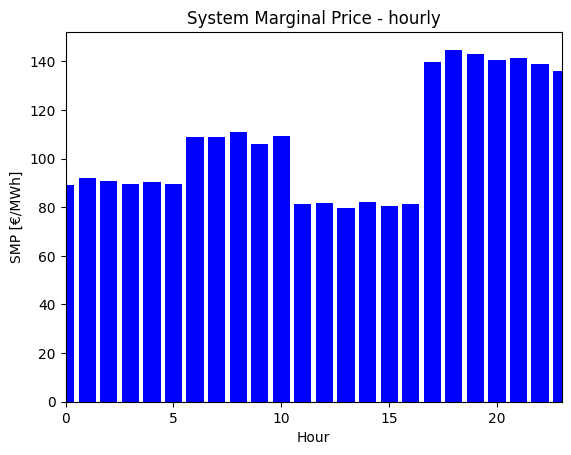

In [84]:
smp = calculate_smp(supply, demand, supply_prices, demand_prices, plot = True)